# RMSE-roughness characterization

The final step after having reconstructed base functions from smooth samples (0.1 nm) and calculating a reference RMSE is to compare rougher samples with respect to this. The roughness parameters are shown in @tbl-2. All the datasets were acquired along the on-axis at +-20 deg and at 7 off-axis positions from -0.15 to 0.15 deg with 0.05 deg steps. 

In [3]:
#| label: tbl-2
#| tbl-cap: Roughness parameters
import pandas as pd
df_datasets_temp = pd.read_csv("../data/c_datasets_table.csv").set_index('wafer')

# df_datasets_temp = df_datasets.drop(['plot', 'baser', 'slice1guess', 'slice2guess', 'slice1', 'slice2', 'location',
#                                      'min_df', 'shifted', 'base', 'dataset', 'normal_slice', 'sliceonedeg'], axis=1)
# df_datasets_temp = df_datasets_temp.rename(columns={'points': 'slices'})
display(df_datasets_temp)

,roughness (nm),points,angle
wafer,,,
W1_0.11nm,0.11,4096,20
W2_0.13nm,0.13,4096,20
W3_0.1 nm,0.10,4096,20
W4_1nm,1.00,4096,20
W5_0.97nm,0.97,4096,20
W6,NaN,4096,20
W7_315nm,315.00,4096,20
W8_5min,NaN,4096,20
W8_4min,NaN,4096,20


The roughness was measured using an atomic force microscope (afm) as shown in @fig-afm

![AFM measurements](figures/d/afm.png){#fig-afm}

## RMSE-roughness bands
@fig-5-1 shows RMSE-roughness characterization using Rockley_ref (0.1 nm) as a reference base function. Notice that there are several bands representing different roughness levels. @fig-5-1 a shows three band levels for the different roughness values including 0.1 nm, 1 nm and $\mu m$. It is possible to differentiate between 0.1 nm and 1 nm levels which is a limitation when using only the Aq values. The 0.1 nm band is between 0 and 15 RMSE, while the 1 nm is 35 and 50 RMSE. 

 @fig-5-2 b shows the RMSE normalized with respect to the amplitude correction factor and using a log scale. In this case the band spacing is wider due to the log scale.

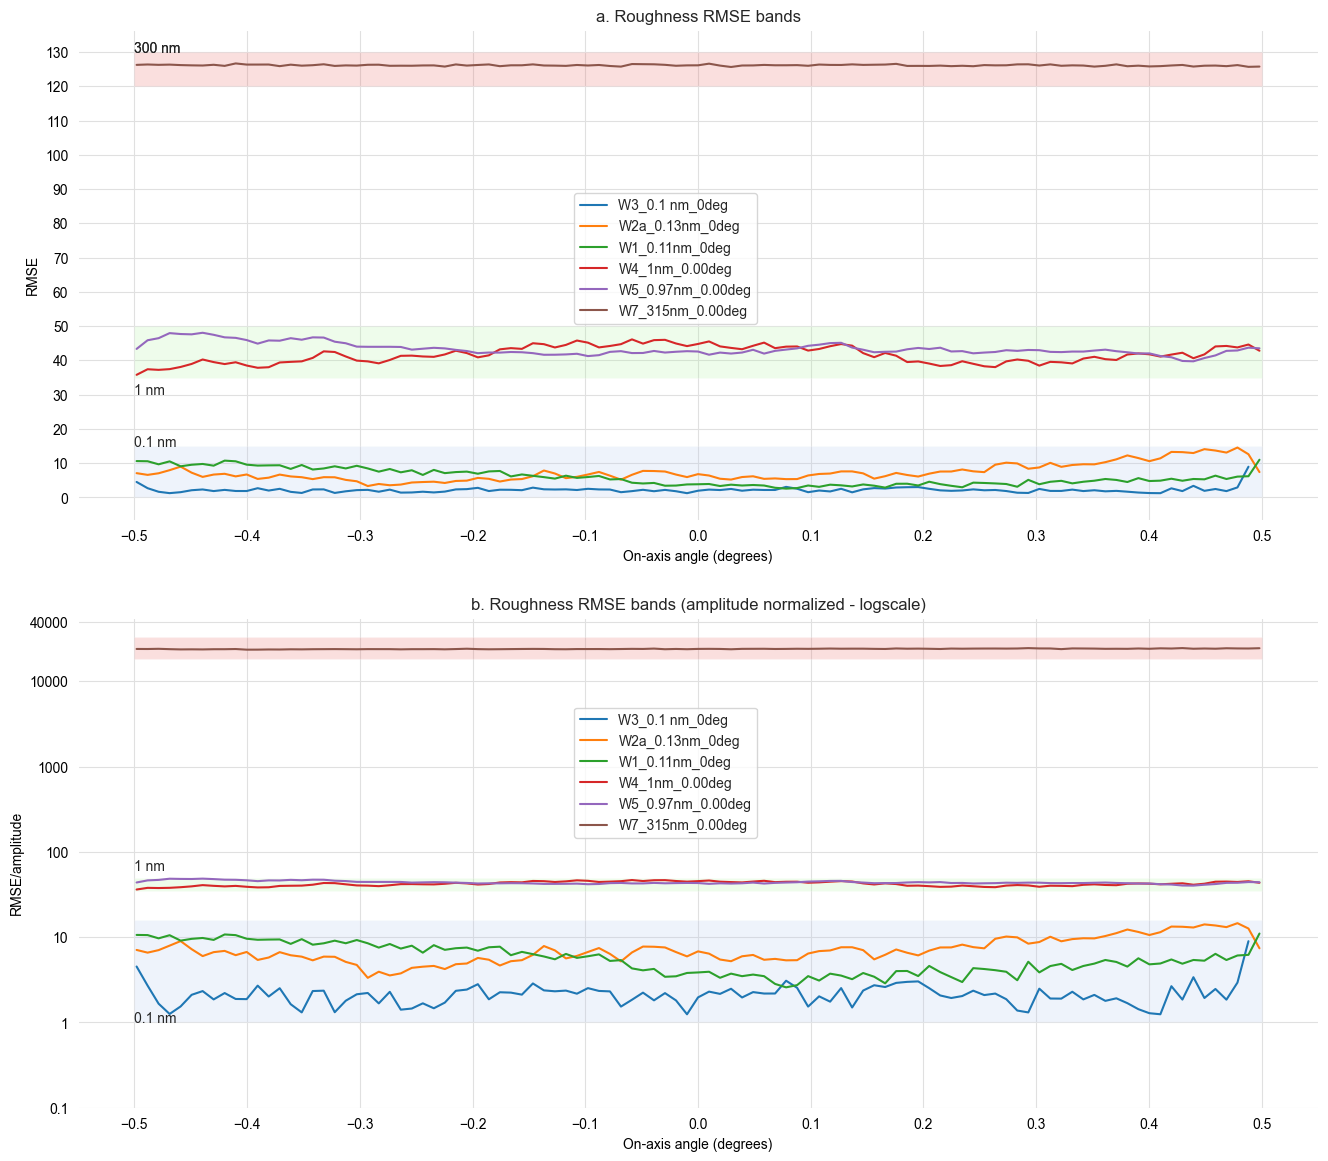

In [11]:
#| label: fig-5-1
#| fig-cap: "Roughness RMSE bands"

from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

my_theme = {
    "figure.facecolor": "white", 
    "axes.facecolor": "white", # green
    "axes.edgecolor": "white",
    "axes.labelcolor": "black",
    "axes.grid": True,
    "grid.color": "#E0E0E0",
    "xtick.color": "black",
    "ytick.color": "black",
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "Tahoma"]
}

def plot_format_plt(xlabel, ylabel, xticks, yticks, ax):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_locator(plt.MultipleLocator(xticks))  # Set x-axis tick frequency
    ax.yaxis.set_major_locator(plt.MultipleLocator(yticks))


def average_base(base_function, window_size):
    x_filtered = base_function['xaxis'].values
    y_filtered = base_function['yaxis'].values
    x_averaged = []
    y_averaged = []
    for i in np.arange(np.min(x_filtered), np.max(x_filtered), window_size):
        # get the indices of the points within the current window
        indices = np.where((x_filtered >= i) & (x_filtered < i + window_size))[0]
        if len(indices) == 0:
            continue
        # calculate the average x and y values for the points in the current window
        x_avg = np.mean(x_filtered[indices])
        y_avg = np.mean(y_filtered[indices])
        x_averaged.append(x_avg)
        y_averaged.append(y_avg)
    return x_averaged, y_averaged

def cost_function(params, y, x, chip):
    """
    Generates a 3D plot of the data

    Parameters
    ----------
    params (list): List of parameters to fit
    y (array): Array with the data to fit
    
    Returns
    -------
    rmse (float): Root mean square error of the fit0.
    """
    x0, A0 = params
    x_new = x + x0
    y_modified = A0*chip(x_new)

    mse = np.mean((y - y_modified) ** 2)
    rmse = np.sqrt(mse)
    return rmse

method = 'Powell'
window_size = 0.05

df_datasets = pd.read_pickle('../data/d_datasets_base.pickle')
df_select = pd.read_excel('../data/d_datasets_base.xlsx', sheet_name='s1').set_index('file')


fig, axes = plt.subplots(2, 1, figsize=(16, 14), squeeze=False)

for reference, rowref in df_select[(df_select['baser'] == 'x') & (df_select['offaxisvalue'] == 0)].iterrows():
    optimized_axis = df_datasets.loc[reference]['shifted']
    
    # Get optimized base function
    optimized_base = df_datasets.loc[reference]['base']
    x_average_opt, y_average_opt = average_base(optimized_base, window_size)
    pchip_optimized = PchipInterpolator(x_average_opt, y_average_opt)
    
    # Get optimized min_df
    optimized_df = df_datasets.loc[reference]['min_df']
    slice1_opt = df_datasets.loc[reference]['slice1'] 
    slice2_opt = df_datasets.loc[reference]['slice2'] 

    label = df_datasets.loc[reference]['label']
    axes[0,0].plot(optimized_df['angle'], optimized_df['rmse'], label=label)
    axes[1,0].plot(optimized_df['angle'], optimized_df['rmse']/optimized_df['amplitude'], label=label)

    for file, row in df_select[(df_select['plot'] == 'x') & (df_select['offaxisvalue']==0)].iterrows():
    # for file, row in df_datasets[(df_datasets['offaxisvalue'] == 0)].iterrows():
        if file != reference and 'min' not in file:
            slice1 = df_datasets.loc[file]['slice1'] 
            slice2 = df_datasets.loc[file]['slice2'] 
            slices = np.arange(slice1, slice2+1, 1)
            offaxis = np.arange(-row.points//2, row.points//2, 1)*(2*row.angle)/row.points - row.displacement
            dataset = df_datasets.loc[file]['dataset']
            minimized_df = pd.DataFrame(columns=["angle", "x0", "difference", "slice", "amplitude", "rmse"])

        for j, slice in enumerate(slices):
                x0 = offaxis[slice]
                Abase = 1.0
                guess = [x0, Abase]

                # Call minimize function
                y = dataset[:, slice]
                cost_fn = lambda p:cost_function(p, y, optimized_axis, pchip_optimized)

                result = minimize(cost_fn, guess, method=method,)
                optimized_parameters = list(result.x)
                x0_opt, A0_opt, = optimized_parameters

                # Calculate optimized function
                x_new_opt = optimized_axis + (x0_opt)
                y_optimized = A0_opt*pchip_optimized(x_new_opt)

                # Calculate error
                mse = np.mean((y - y_optimized) ** 2)
                rmse = np.sqrt(mse)
                minimized_df.loc[j] = [offaxis[slice], x0_opt, offaxis[slice] - x0_opt, slice, A0_opt, rmse]

        label = df_datasets.loc[file]['label']
        axes[0,0].plot(minimized_df['angle'], minimized_df['rmse'], label=label)
        axes[1,0].plot(minimized_df['angle'], minimized_df['rmse']/minimized_df['amplitude'], label=label)

rect1 = patches.Rectangle((-0.5, 0), 1.0, 15, alpha=0.2, facecolor='#AEC5EB')
rect2 = patches.Rectangle((-0.5, 35), 1.0, 15, alpha=0.2, facecolor='#ACF39D')
rect3 = patches.Rectangle((-0.5, 120), 1.0, 10, alpha=0.2, facecolor='#E85F5C')
axes[0,0].add_patch(rect1)
axes[0,0].add_patch(rect2)
axes[0,0].add_patch(rect3)

# add text
axes[0,0].text(-0.5, 15, '0.1 nm', fontsize=10)
axes[0,0].text(-0.5, 30, '1 nm', fontsize=10)
axes[0,0].text(-0.5, 130, '300 nm', fontsize=10)

plt.legend();
axes[0,0].legend(loc=(0.4, 0.4))

# format
plot_format_plt('On-axis angle (degrees)', 'RMSE', 0.1, 10, axes[0,0])
axes[0,0].set_title('a. Roughness RMSE bands')

rect1 = patches.Rectangle((-0.5, 1), 1.0, 15, alpha=0.2, facecolor='#AEC5EB')
rect2 = patches.Rectangle((-0.5, 35), 1.0, 15, alpha=0.2, facecolor='#ACF39D')
rect3 = patches.Rectangle((-0.5, 18000), 1.0, 15000, alpha=0.2, facecolor='#E85F5C')
axes[1,0].add_patch(rect1)
axes[1,0].add_patch(rect2)
axes[1,0].add_patch(rect3)


axes[1,0].set_yscale('log')
plot_format_plt('On-axis angle (degrees)', 'RMSE/amplitude', 0.1, 10, axes[1,0])
yticks = [0.1, 1, 10, 100, 1000, 10000, 50000]
yticklabels = ['0.1', '1', '10', '100', '1000', '10000', '40000']
axes[1,0].set_yticks(yticks)
axes[1,0].set_yticklabels(yticklabels)
axes[1,0].legend(loc=(0.4, 0.55))
axes[1,0].set_title('b. Roughness RMSE bands (amplitude normalized - logscale)')


axes[1,0].text(-0.5, 1, '0.1 nm', fontsize=10)
axes[1,0].text(-0.5, 60, '1 nm', fontsize=10)
axes[0,0].text(-0.5, 130, '300 nm', fontsize=10)
sns.set_style("white", rc=my_theme)

A comparison of the same roughness values but using the Aq values is shown in @fig-5-2. Notice the Aq values have a cosine shape and the 0.1 nm and 1 nm bands are not clearly separated. This is because for very smooth wafer the sampling points are limited over the main curve, hence the Aq values are not very sensitive to roughness changes in the nm scale. When focusing only in +-0.1 deg the Aq values seem to have a band behaviour, however because of the very small Aq values the resolution is too small to clearly distinguish between the different roughness levels.

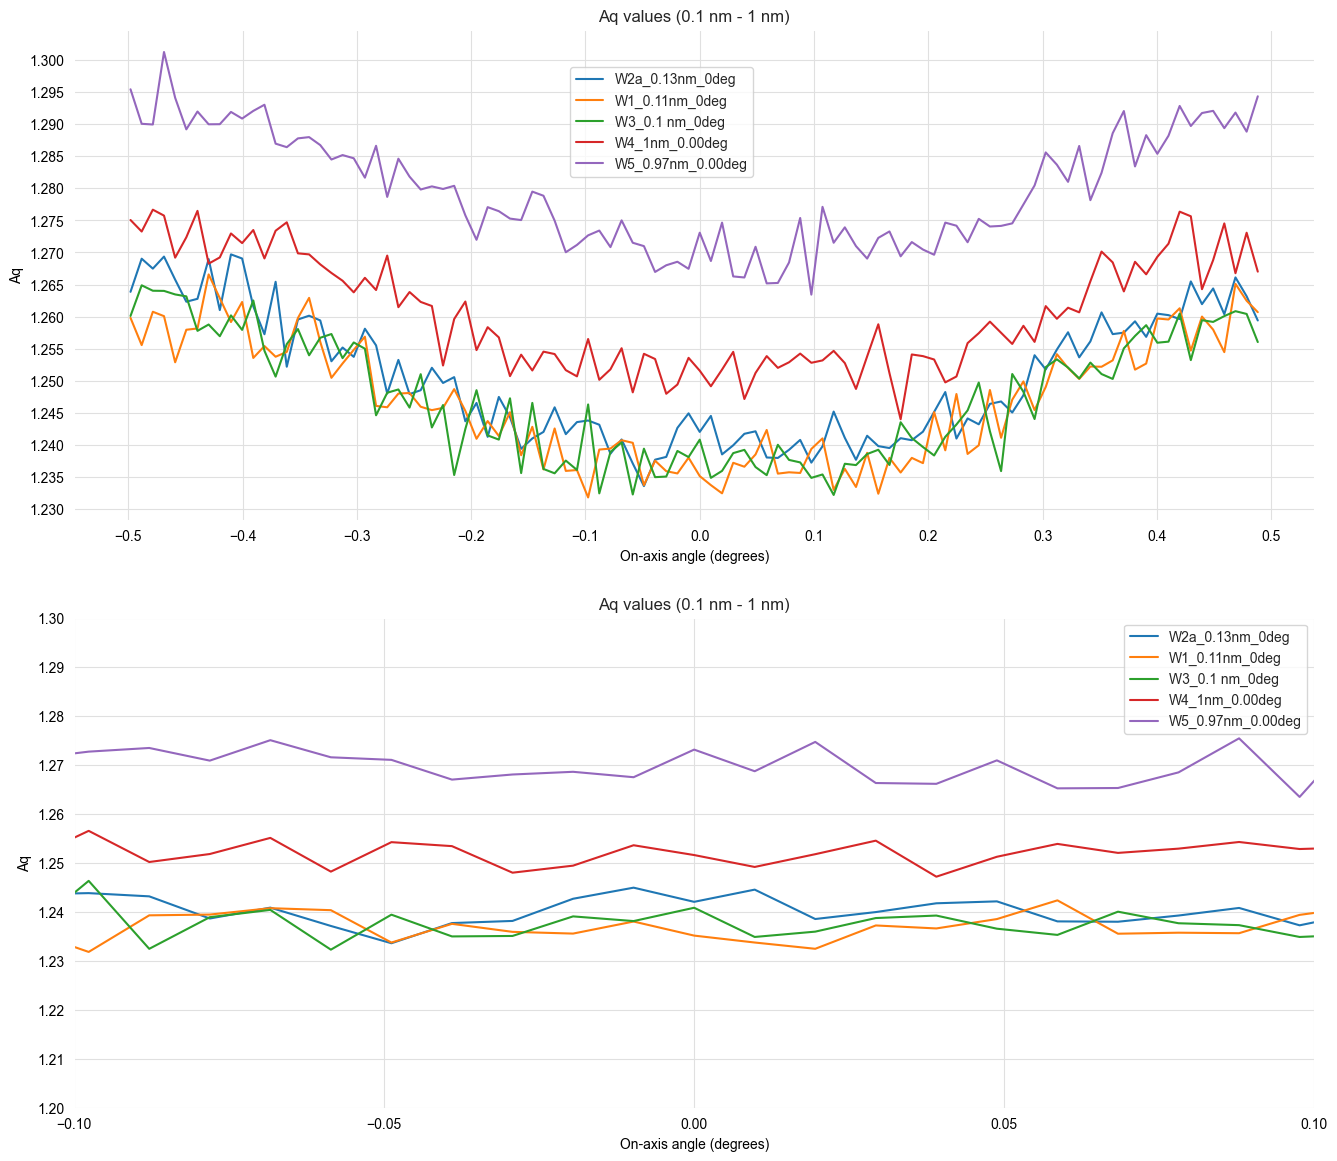

In [25]:
#| label: fig-5-2
#| fig-cap: "Aq values"
df_datasets = pd.read_pickle('../data/d_datasets_base.pickle')
df_select = pd.read_excel('../data/d_datasets_base.xlsx', sheet_name='s5').set_index('file')

fig, axes = plt.subplots(2, 1, figsize=(16, 14), squeeze=False)
for file, row in df_select[(df_select['plot'] == 'x') & (df_select['offaxisvalue'] == 0)].iterrows():
    slice1 = df_datasets.loc[file]['slice1'] 
    slice2 = df_datasets.loc[file]['slice2'] 
    slices = np.arange(slice1, slice2, 1)
    offaxis = np.arange(-row.points//2, row.points//2, 1)*(2*row.angle)/row.points - row.displacement
   
    dataset = df_datasets.loc[file]['dataset']
    optimized_axis = df_datasets.loc['Rockley_ref_0.000.csv']['shifted']
    optimized_df = df_datasets.loc[file]['min_df']

    std_dev = []
    for j, slice in enumerate(slices):
        # print(slice)
        yvalues = dataset[:, slice]
        # x0 = optimized_df.loc[slice]['x0']
        x0 = offaxis[slice]
        stddev = np.sqrt(np.sum(yvalues * (optimized_axis + x0)**2) / np.sum(yvalues))
        std_dev.append(stddev)

        # stddev=(sqrt(sum(yvalues.*(xaxis-x0).^2)/sum(yvalues)))
    if row.roughness < 1.1:
        
        axes[0,0].plot(offaxis[slices], std_dev, label=df_datasets.loc[file]['label'])
        axes[1,0].plot(offaxis[slices], std_dev, label=df_datasets.loc[file]['label'])

plt.legend();
axes[0,0].legend(loc=(0.4, 0.7))
axes[0,0].set_title('Aq values (0.1 nm - 1 nm)')
axes[1,0].set_title('Aq values (0.1 nm - 1 nm)')
axes[1,0].set_xlim(-0.1, 0.1)
axes[1,0].set_ylim(1.2, 1.3)
plot_format_plt('On-axis angle (degrees)', 'Aq', 0.1, 0.005, axes[0,0])
plot_format_plt('On-axis angle (degrees)', 'Aq', 0.05, 0.01, axes[1,0])

## RMSE-roughness wafer polishing
@fig-5-3 shows the relationship between roughness and polishing time of a wafer. The more polishing time the smoother the wafer becomes as expected. A time longer than 5 min is required to obtain a roughness below 1 nm. With this propose methodology it is possible to characterize different wafers after polishing and compare them with respect to a reference wafer.

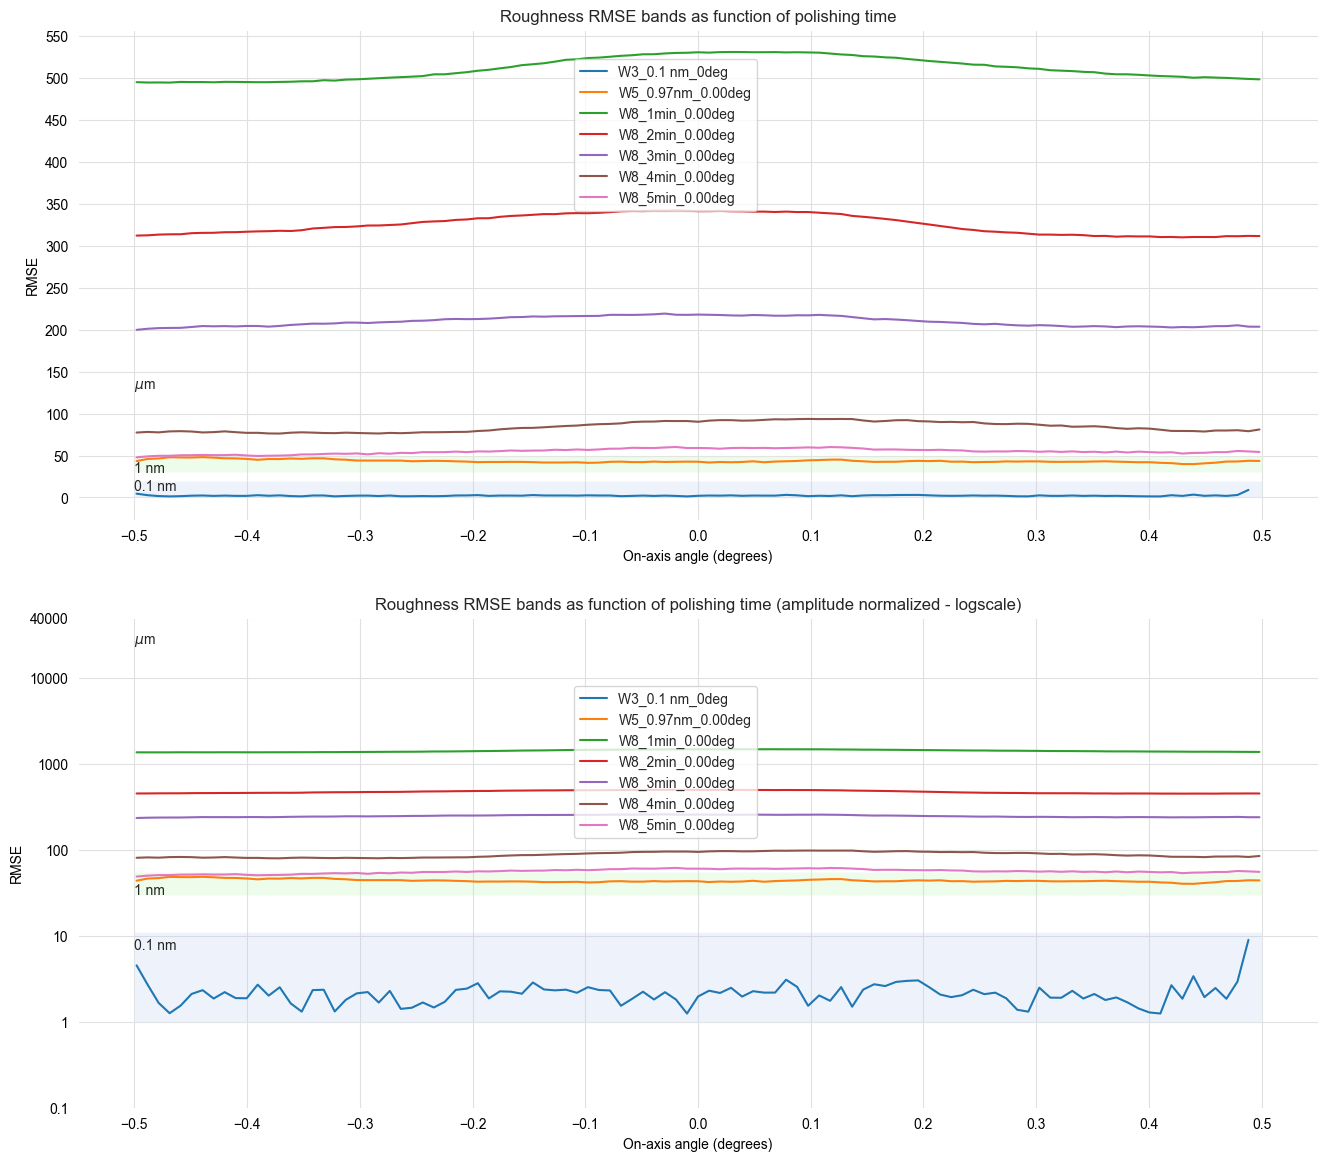

In [15]:
#| label: fig-5-3
#| fig-cap: "Roughness RMSE bands"

from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

my_theme = {
    "figure.facecolor": "white", 
    "axes.facecolor": "white", # green
    "axes.edgecolor": "white",
    "axes.labelcolor": "black",
    "axes.grid": True,
    "grid.color": "#E0E0E0",
    "xtick.color": "black",
    "ytick.color": "black",
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "Tahoma"]
}

def plot_format_plt(xlabel, ylabel, xticks, yticks, ax):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_locator(plt.MultipleLocator(xticks))  # Set x-axis tick frequency
    ax.yaxis.set_major_locator(plt.MultipleLocator(yticks))


def average_base(base_function, window_size):
    x_filtered = base_function['xaxis'].values
    y_filtered = base_function['yaxis'].values
    x_averaged = []
    y_averaged = []
    for i in np.arange(np.min(x_filtered), np.max(x_filtered), window_size):
        # get the indices of the points within the current window
        indices = np.where((x_filtered >= i) & (x_filtered < i + window_size))[0]
        if len(indices) == 0:
            continue
        # calculate the average x and y values for the points in the current window
        x_avg = np.mean(x_filtered[indices])
        y_avg = np.mean(y_filtered[indices])
        x_averaged.append(x_avg)
        y_averaged.append(y_avg)
    return x_averaged, y_averaged

def cost_function(params, y, x, chip):
    """
    Generates a 3D plot of the data

    Parameters
    ----------
    params (list): List of parameters to fit
    y (array): Array with the data to fit
    
    Returns
    -------
    rmse (float): Root mean square error of the fit0.
    """
    x0, A0 = params
    x_new = x + x0
    y_modified = A0*chip(x_new)

    mse = np.mean((y - y_modified) ** 2)
    rmse = np.sqrt(mse)
    return rmse

method = 'Powell'
window_size = 0.05

reference_base = ['Rockley_ref_0.000.csv']
df_datasets = pd.read_pickle('../data/d_datasets_base.pickle')
df_select = pd.read_excel('../data/d_datasets_base.xlsx', sheet_name='s2').set_index('file')


fig, axes = plt.subplots(2, 1, figsize=(16, 14), squeeze=False)

for reference, rowref in df_select[(df_select['baser'] == 'x') & (df_select['offaxisvalue'] == 0)].iterrows():
    optimized_axis = df_datasets.loc[reference]['shifted']
    
    # Get optimized base function
    optimized_base = df_datasets.loc[reference]['base']
    x_average_opt, y_average_opt = average_base(optimized_base, window_size)
    pchip_optimized = PchipInterpolator(x_average_opt, y_average_opt)
    
    # Get optimized min_df
    optimized_df = df_datasets.loc[reference]['min_df']
    slice1_opt = df_datasets.loc[reference]['slice1'] 
    slice2_opt = df_datasets.loc[reference]['slice2'] 

    label = df_datasets.loc[reference]['label']
    axes[0,0].plot(optimized_df['angle'], optimized_df['rmse'], label=label)
    axes[1,0].plot(optimized_df['angle'], optimized_df['rmse']/optimized_df['amplitude'], label=label)

    for file, row in df_select[(df_select['plot'] == 'x') & (df_select['offaxisvalue']==0)].iterrows():
    # for file, row in df_datasets[(df_datasets['offaxisvalue'] == 0)].iterrows():
        if file != reference:
            slice1 = df_datasets.loc[file]['slice1'] 
            slice2 = df_datasets.loc[file]['slice2'] 
            slices = np.arange(slice1, slice2+1, 1)
            offaxis = np.arange(-row.points//2, row.points//2, 1)*(2*row.angle)/row.points - row.displacement
            dataset = df_datasets.loc[file]['dataset']
            minimized_df = pd.DataFrame(columns=["angle", "x0", "difference", "slice", "amplitude", "rmse"])

        for j, slice in enumerate(slices):
                x0 = offaxis[slice]
                Abase = 1.0
                guess = [x0, Abase]

                # Call minimize function
                y = dataset[:, slice]
                cost_fn = lambda p:cost_function(p, y, optimized_axis, pchip_optimized)

                result = minimize(cost_fn, guess, method=method,)
                optimized_parameters = list(result.x)
                x0_opt, A0_opt, = optimized_parameters

                # Calculate optimized function
                x_new_opt = optimized_axis + (x0_opt)
                y_optimized = A0_opt*pchip_optimized(x_new_opt)

                # Calculate error
                mse = np.mean((y - y_optimized) ** 2)
                rmse = np.sqrt(mse)
                minimized_df.loc[j] = [offaxis[slice], x0_opt, offaxis[slice] - x0_opt, slice, A0_opt, rmse]

        label = df_datasets.loc[file]['label']
        axes[0,0].plot(minimized_df['angle'], minimized_df['rmse'], label=label)
        axes[1,0].plot(minimized_df['angle'], minimized_df['rmse']/minimized_df['amplitude'], label=label)

rect1 = patches.Rectangle((-0.5, 0), 1.0, 20, alpha=0.2, facecolor='#AEC5EB')
rect2 = patches.Rectangle((-0.5, 30), 1.0, 20, alpha=0.2, facecolor='#ACF39D')
rect3 = patches.Rectangle((-0.5, 120), 1.0, 40, alpha=0.2, facecolor='#E85F5C')
axes[0,0].add_patch(rect1)
axes[0,0].add_patch(rect2)
# axes[0,0].add_patch(rect3)

# add text
axes[0,0].text(-0.5, 8, '0.1 nm', fontsize=10)
axes[0,0].text(-0.5, 30, '1 nm', fontsize=10)
axes[0,0].text(-0.5, 130, r'$\mu$m', fontsize=10)

plt.legend();
axes[0,0].legend(loc=(0.4, 0.63))

# format
plot_format_plt('On-axis angle (degrees)', 'RMSE', 0.1, 50, axes[0,0])
axes[0,0].set_title('Roughness RMSE bands as function of polishing time')

rect1 = patches.Rectangle((-0.5, 1), 1.0, 10, alpha=0.2, facecolor='#AEC5EB')
rect2 = patches.Rectangle((-0.5, 30), 1.0, 25, alpha=0.2, facecolor='#ACF39D')
rect3 = patches.Rectangle((-0.5, 18000), 1.0, 15000, alpha=0.2, facecolor='#E85F5C')
axes[1,0].add_patch(rect1)
axes[1,0].add_patch(rect2)
# axes[1,0].add_patch(rect3)


axes[1,0].set_yscale('log')
plot_format_plt('On-axis angle (degrees)', 'RMSE', 0.1, 10, axes[1,0])
yticks = [0.1, 1, 10, 100, 1000, 10000, 50000]
yticklabels = ['0.1', '1', '10', '100', '1000', '10000', '40000']
axes[1,0].set_yticks(yticks)
axes[1,0].set_yticklabels(yticklabels)
axes[1,0].legend(loc=(0.4, 0.55))
axes[1,0].set_title('Roughness RMSE bands as function of polishing time (amplitude normalized - logscale)')

axes[1,0].text(-0.5, 7, '0.1 nm', fontsize=10)
axes[1,0].text(-0.5, 30, '1 nm', fontsize=10)
axes[1,0].text(-0.5, 25000, r'$\mu$m', fontsize=10);


## Repeatability and data conditions.

In order to know the requirements of the off-axis aligment different off-axis datasets as the one shown in @fig-3-9 were acquired. The RMSE was then calculated using the same method. The results are: 

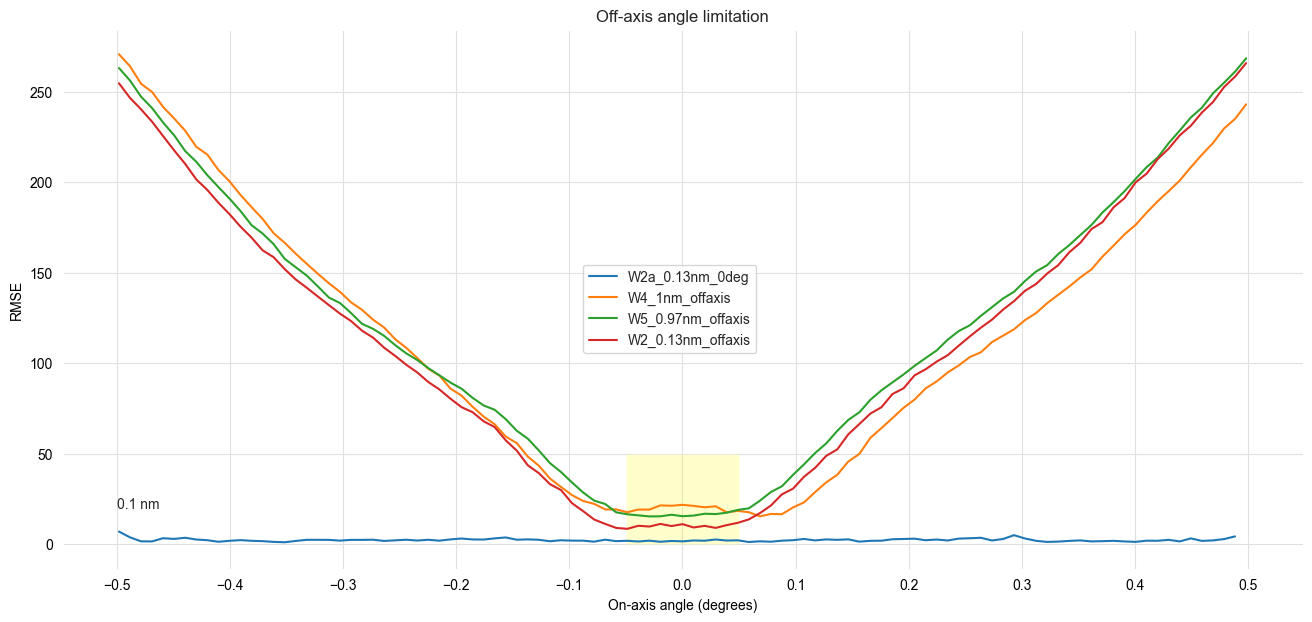

In [17]:
#| label: fig-5-4
#| fig-cap: "Off-axis angle limitations"

df_select = pd.read_excel('../data/d_datasets_base.xlsx', sheet_name='s6').set_index('file')

fig, ax = plt.subplots(figsize=(16, 7))

for reference, rowref in df_select[(df_select['baser'] == 'x')].iterrows():
    optimized_axis = df_datasets.loc[reference]['shifted']
    
    # Get optimized base function
    optimized_base = df_datasets.loc[reference]['base']
    x_average_opt, y_average_opt = average_base(optimized_base, window_size)
    pchip_optimized = PchipInterpolator(x_average_opt, y_average_opt)
    
    # Get optimized min_df
    optimized_df = df_datasets.loc[reference]['min_df']
    slice1_opt = df_datasets.loc[reference]['slice1'] 
    slice2_opt = df_datasets.loc[reference]['slice2'] 

    label = df_datasets.loc[reference]['label']
    ax.plot(optimized_df['angle'], optimized_df['rmse'], label=label)
    
    for file, row in df_select[(df_select['plot'] == 'x')].iterrows():
    # for file, row in df_datasets[(df_datasets['offaxisvalue'] == 0)].iterrows():
        if file != reference:
            
            slice1 = df_datasets.loc[file]['slice1'] 
            slice2 = df_datasets.loc[file]['slice2'] 
            slices = np.arange(slice1, slice2+1, 1)
            offaxis = np.arange(-row.points//2, row.points//2, 1)*(2*row.angle)/row.points - row.displacement
            dataset = df_datasets.loc[file]['dataset']
            minimized_df = pd.DataFrame(columns=["angle", "x0", "difference", "slice", "amplitude", "rmse"])

        for j, slice in enumerate(slices):
                x0 = offaxis[slice]
                Abase = 1.0
                guess = [x0, Abase]

                # Call minimize function
                y = dataset[:, slice]
                cost_fn = lambda p:cost_function(p, y, optimized_axis, pchip_optimized)

                result = minimize(cost_fn, guess, method=method,)
                optimized_parameters = list(result.x)
                x0_opt, A0_opt, = optimized_parameters

                # Calculate optimized function
                x_new_opt = optimized_axis + (x0_opt)
                y_optimized = A0_opt*pchip_optimized(x_new_opt)

                # Calculate error
                mse = np.mean((y - y_optimized) ** 2)
                rmse = np.sqrt(mse)
                minimized_df.loc[j] = [offaxis[slice], x0_opt, offaxis[slice] - x0_opt, slice, A0_opt, rmse]

        label = df_datasets.loc[file]['label']
        ax.plot(minimized_df['angle'], minimized_df['rmse'], label=label)
        

rect1 = patches.Rectangle((-0.05, 0), 0.1, 50, alpha=0.2, facecolor='yellow')
rect2 = patches.Rectangle((-0.5, 0), 0.45, 240, alpha=0.2, facecolor='#93827F')
rect3 = patches.Rectangle((0.05, 0), 0.4, 240, alpha=0.2, facecolor='#93827F')
ax.add_patch(rect1)
# ax.add_patch(rect2)
# ax.add_patch(rect3)


ax.text(-0.5, 20, '0.1 nm', fontsize=10);

ax.legend();
ax.legend(loc=(0.42, 0.4))
plot_format_plt('On-axis angle (degrees)', 'RMSE', 0.1, 50, ax)

ax.set_title('Off-axis angle limitation');

In this case the results imply that the data needs to be collected at off-axis positions withing +-0.05 deg in order to obtain reproducible results. Notice outside this range the error increases significantly. Hence, in practice there has to be a precise control over the scanning angles using a vacuum in a clean room to make sure the data is collected within the required scanning on-axis and off-axis angles. This limitation is illustrated in @fig-5-5 , in this case the Ann10 wafer at 0 deg was used as the reference base function. Then the same wafer was fit and the RMSE was calculated but at different off-axis positions. Notice how the RMSE results are not consistent with the reference base function. 

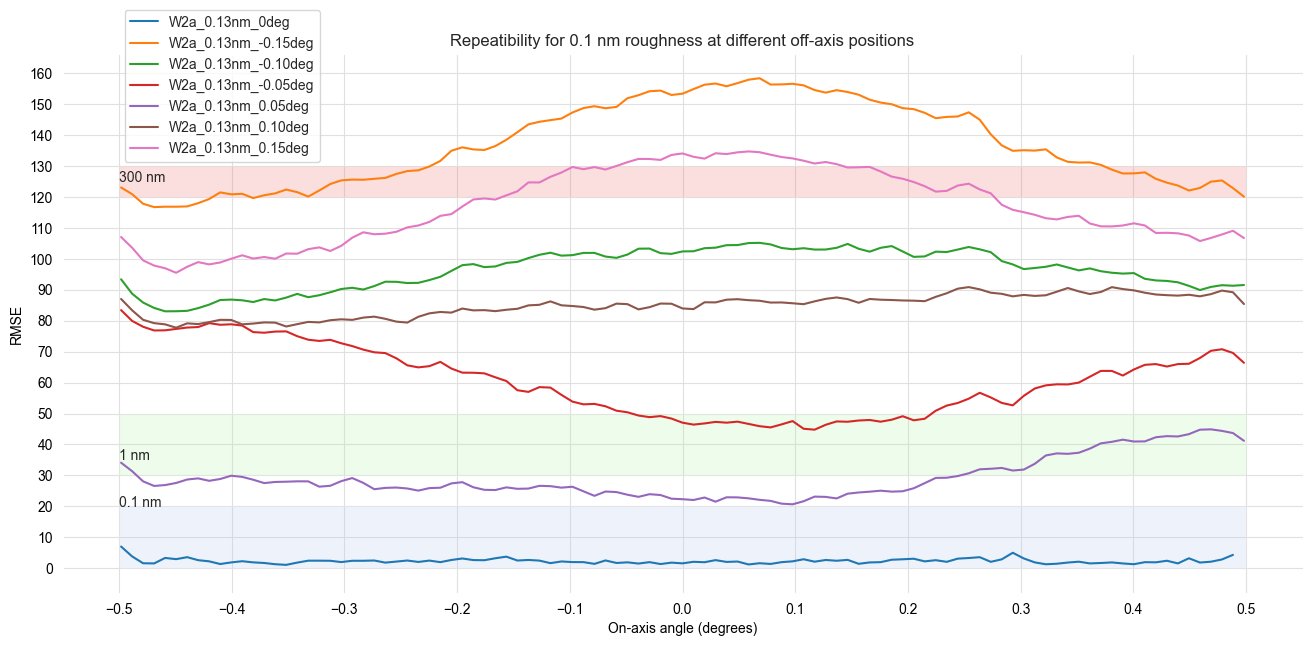

In [19]:
#| label: fig-5-5
#| fig-cap: "Repeatibility for 0.1 nm roughness at different off-axis positions"

df_select = pd.read_excel('../data/d_datasets_base.xlsx', sheet_name='s7').set_index('file')

fig, ax = plt.subplots(figsize=(16, 7))

for reference, rowref in df_select[(df_select['baser'] == 'x')].iterrows():
    optimized_axis = df_datasets.loc[reference]['shifted']
    
    # Get optimized base function
    optimized_base = df_datasets.loc[reference]['base']
    x_average_opt, y_average_opt = average_base(optimized_base, window_size)
    pchip_optimized = PchipInterpolator(x_average_opt, y_average_opt)
    
    # Get optimized min_df
    optimized_df = df_datasets.loc[reference]['min_df']
    slice1_opt = df_datasets.loc[reference]['slice1'] 
    slice2_opt = df_datasets.loc[reference]['slice2'] 

    label = df_datasets.loc[reference]['label']
    ax.plot(optimized_df['angle'], optimized_df['rmse'], label=label)
    
    for file, row in df_select[(df_select['plot'] == 'x')].iterrows():
    # for file, row in df_datasets[(df_datasets['offaxisvalue'] == 0)].iterrows():
        if file != reference and 'min' not in file:
            slice1 = df_datasets.loc[file]['slice1'] 
            slice2 = df_datasets.loc[file]['slice2'] 
            slices = np.arange(slice1, slice2+1, 1)
            offaxis = np.arange(-row.points//2, row.points//2, 1)*(2*row.angle)/row.points - row.displacement
            dataset = df_datasets.loc[file]['dataset']
            minimized_df = pd.DataFrame(columns=["angle", "x0", "difference", "slice", "amplitude", "rmse"])

        for j, slice in enumerate(slices):
                x0 = offaxis[slice]
                Abase = 1.0
                guess = [x0, Abase]

                # Call minimize function
                y = dataset[:, slice]
                cost_fn = lambda p:cost_function(p, y, optimized_axis, pchip_optimized)

                result = minimize(cost_fn, guess, method=method,)
                optimized_parameters = list(result.x)
                x0_opt, A0_opt, = optimized_parameters

                # Calculate optimized function
                x_new_opt = optimized_axis + (x0_opt)
                y_optimized = A0_opt*pchip_optimized(x_new_opt)

                # Calculate error
                mse = np.mean((y - y_optimized) ** 2)
                rmse = np.sqrt(mse)
                minimized_df.loc[j] = [offaxis[slice], x0_opt, offaxis[slice] - x0_opt, slice, A0_opt, rmse]

        label = df_datasets.loc[file]['label']
        ax.plot(minimized_df['angle'], minimized_df['rmse'], label=label)
        

rect1 = patches.Rectangle((-0.5, 0), 1.0, 20, alpha=0.2, facecolor='#AEC5EB')
rect2 = patches.Rectangle((-0.5, 30), 1.0, 20, alpha=0.2, facecolor='#ACF39D')
rect3 = patches.Rectangle((-0.5, 120), 1.0, 10, alpha=0.2, facecolor='#E85F5C')

ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

ax.text(-0.5, 20, '0.1 nm', fontsize=10);
ax.text(-0.5, 35, '1 nm', fontsize=10)
ax.text(-0.5, 125, '300 nm', fontsize=10)

ax.legend();
ax.legend(loc=(0.05, 0.8))
plot_format_plt('On-axis angle (degrees)', 'RMSE', 0.1, 10, ax)

ax.set_title('Repeatibility for 0.1 nm roughness at different off-axis positions');

A similar situation is illustrated in @fig-5-6 , in this case the Ann10a was used as a reference base function. Notice how the orange curve is outside the 0.1 nm band. This is due to scratches/dust in the wafer that can affect the roughness characterization. Hence, it is important to have a clean wafer under control enviroments that can be met in a controlled clean room.

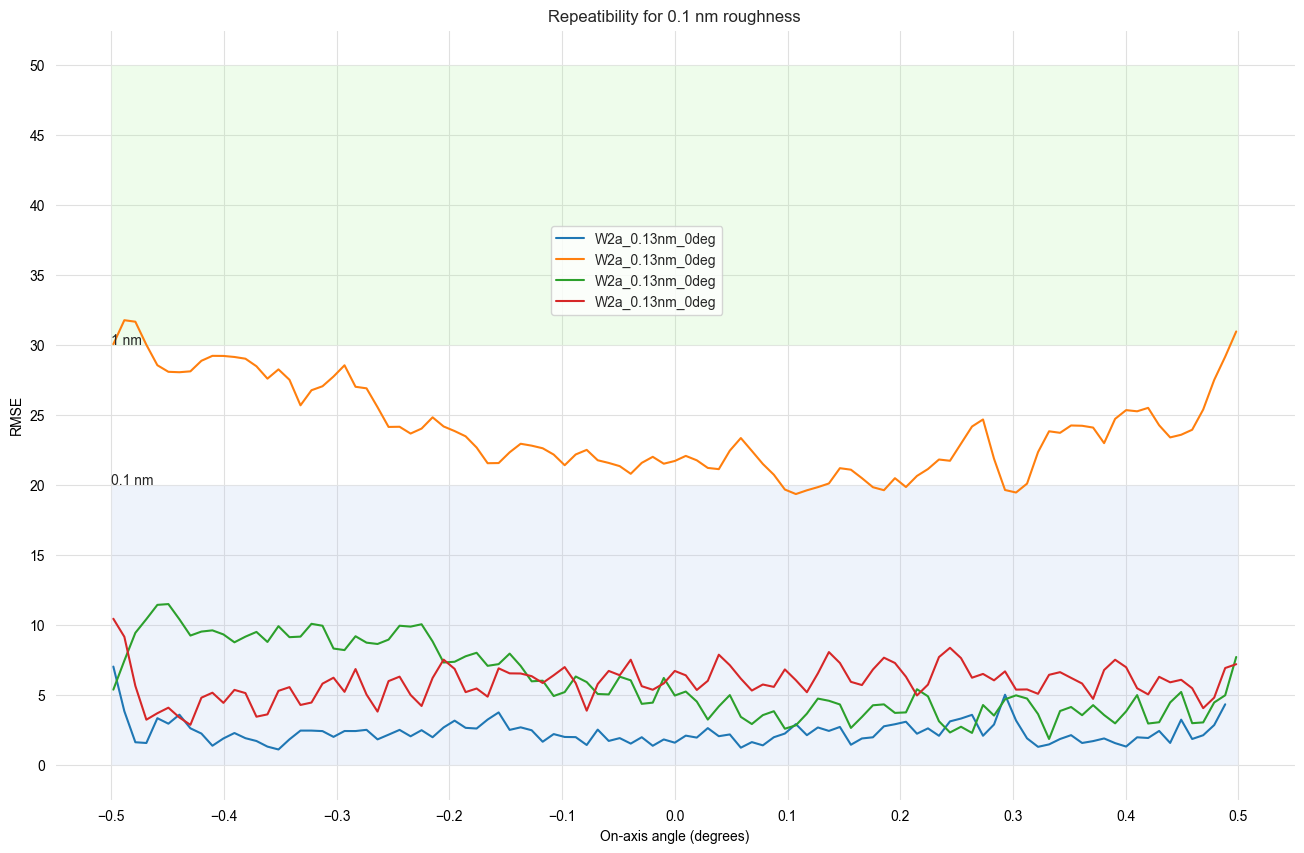

In [20]:
#| label: fig-5-6
#| fig-cap: "Repeatibility of RMSE roughness in the same wafer"
df_select = pd.read_excel('../data/d_datasets_base.xlsx', sheet_name='s3').set_index('file')

fig, ax = plt.subplots(figsize=(16, 10))

for reference, rowref in df_select[(df_select['baser'] == 'x') & (df_select['offaxisvalue'] == 0)].iterrows():
    optimized_axis = df_datasets.loc[reference]['shifted']
    
    # Get optimized base function
    optimized_base = df_datasets.loc[reference]['base']
    x_average_opt, y_average_opt = average_base(optimized_base, window_size)
    pchip_optimized = PchipInterpolator(x_average_opt, y_average_opt)
    
    # Get optimized min_df
    optimized_df = df_datasets.loc[reference]['min_df']
    slice1_opt = df_datasets.loc[reference]['slice1'] 
    slice2_opt = df_datasets.loc[reference]['slice2'] 

    label = df_datasets.loc[reference]['label']
    ax.plot(optimized_df['angle'], optimized_df['rmse'], label=label)
    
    for file, row in df_select[(df_select['plot'] == 'x') & (df_select['offaxisvalue']==0)].iterrows():
    # for file, row in df_datasets[(df_datasets['offaxisvalue'] == 0)].iterrows():
        if file != reference and 'min' not in file:
            slice1 = df_datasets.loc[file]['slice1'] 
            slice2 = df_datasets.loc[file]['slice2'] 
            slices = np.arange(slice1, slice2+1, 1)
            offaxis = np.arange(-row.points//2, row.points//2, 1)*(2*row.angle)/row.points - row.displacement
            dataset = df_datasets.loc[file]['dataset']
            minimized_df = pd.DataFrame(columns=["angle", "x0", "difference", "slice", "amplitude", "rmse"])

        for j, slice in enumerate(slices):
                x0 = offaxis[slice]
                Abase = 1.0
                guess = [x0, Abase]

                # Call minimize function
                y = dataset[:, slice]
                cost_fn = lambda p:cost_function(p, y, optimized_axis, pchip_optimized)

                result = minimize(cost_fn, guess, method=method,)
                optimized_parameters = list(result.x)
                x0_opt, A0_opt, = optimized_parameters

                # Calculate optimized function
                x_new_opt = optimized_axis + (x0_opt)
                y_optimized = A0_opt*pchip_optimized(x_new_opt)

                # Calculate error
                mse = np.mean((y - y_optimized) ** 2)
                rmse = np.sqrt(mse)
                minimized_df.loc[j] = [offaxis[slice], x0_opt, offaxis[slice] - x0_opt, slice, A0_opt, rmse]

        label = df_datasets.loc[reference]['label']

        ax.plot(minimized_df['angle'], minimized_df['rmse'], label=label)
        

rect1 = patches.Rectangle((-0.5, 0), 1.0, 20, alpha=0.2, facecolor='#AEC5EB')
rect2 = patches.Rectangle((-0.5, 30), 1.0, 20, alpha=0.2, facecolor='#ACF39D')


ax.add_patch(rect1)
ax.add_patch(rect2)

ax.text(-0.5, 20, '0.1 nm', fontsize=10);
ax.text(-0.5, 30, '1 nm', fontsize=10)

ax.legend();
ax.legend(loc=(0.4, 0.63))
plot_format_plt('On-axis angle (degrees)', 'RMSE', 0.1, 5, ax)

ax.set_title('Repeatibility for 0.1 nm roughness');


Finally when using a 0.1 nm wafer as a refence function at 0 deg off-axis and fitting Ann 5 (1 nm) at different off-axis positions the result is not repeatable. For different off-axis positions the RMSE is not consistent and outside the expected 1 nm band. This is illustrated in @fig-5-7.

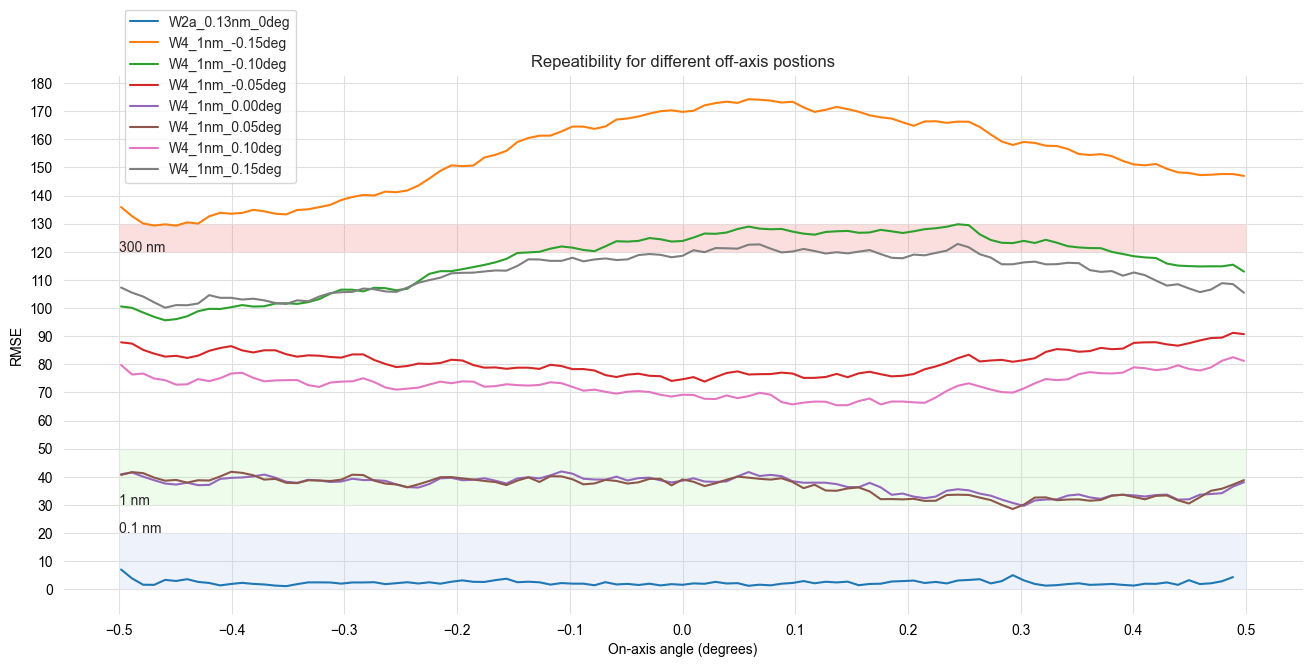

In [21]:
#| label: fig-5-7
#| fig-cap: "Repeatibility for 0.1 nm roughness at different off-axis positions"

df_select = pd.read_excel('../data/d_datasets_base.xlsx', sheet_name='s8').set_index('file')

fig, ax = plt.subplots(figsize=(16, 7))

for reference, rowref in df_select[(df_select['baser'] == 'x')].iterrows():
    optimized_axis = df_datasets.loc[reference]['shifted']
    
    # Get optimized base function
    optimized_base = df_datasets.loc[reference]['base']
    x_average_opt, y_average_opt = average_base(optimized_base, window_size)
    pchip_optimized = PchipInterpolator(x_average_opt, y_average_opt)
    
    # Get optimized min_df
    optimized_df = df_datasets.loc[reference]['min_df']
    slice1_opt = df_datasets.loc[reference]['slice1'] 
    slice2_opt = df_datasets.loc[reference]['slice2'] 

    label = df_datasets.loc[reference]['label']

    ax.plot(optimized_df['angle'], optimized_df['rmse'], label=label)
    
    for file, row in df_select[(df_select['plot'] == 'x')].iterrows():
    # for file, row in df_datasets[(df_datasets['offaxisvalue'] == 0)].iterrows():
        if file != reference and 'min' not in file:
            slice1 = df_datasets.loc[file]['slice1'] 
            slice2 = df_datasets.loc[file]['slice2'] 
            slices = np.arange(slice1, slice2+1, 1)
            offaxis = np.arange(-row.points//2, row.points//2, 1)*(2*row.angle)/row.points - row.displacement
            dataset = df_datasets.loc[file]['dataset']
            minimized_df = pd.DataFrame(columns=["angle", "x0", "difference", "slice", "amplitude", "rmse"])

        for j, slice in enumerate(slices):
                x0 = offaxis[slice]
                Abase = 1.0
                guess = [x0, Abase]

                # Call minimize function
                y = dataset[:, slice]
                cost_fn = lambda p:cost_function(p, y, optimized_axis, pchip_optimized)

                result = minimize(cost_fn, guess, method=method,)
                optimized_parameters = list(result.x)
                x0_opt, A0_opt, = optimized_parameters

                # Calculate optimized function
                x_new_opt = optimized_axis + (x0_opt)
                y_optimized = A0_opt*pchip_optimized(x_new_opt)

                # Calculate error
                mse = np.mean((y - y_optimized) ** 2)
                rmse = np.sqrt(mse)
                minimized_df.loc[j] = [offaxis[slice], x0_opt, offaxis[slice] - x0_opt, slice, A0_opt, rmse]

        label = df_datasets.loc[file]['label']

        ax.plot(minimized_df['angle'], minimized_df['rmse'], label=label)
        

rect1 = patches.Rectangle((-0.5, 0), 1.0, 20, alpha=0.2, facecolor='#AEC5EB')
rect2 = patches.Rectangle((-0.5, 30), 1.0, 20, alpha=0.2, facecolor='#ACF39D')
rect3 = patches.Rectangle((-0.5, 120), 1.0, 10, alpha=0.2, facecolor='#E85F5C')
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

ax.text(-0.5, 20, '0.1 nm', fontsize=10);
ax.text(-0.5, 30, '1 nm', fontsize=10)
ax.text(-0.5, 120, '300 nm', fontsize=10)

ax.legend();
ax.legend(loc=(0.05, 0.8))
plot_format_plt('On-axis angle (degrees)', 'RMSE', 0.1, 10, ax)

ax.set_title('Repeatibility for different off-axis postions');

# Conclusions

1. A new methodology has been presented in order to characterize wafer with roughness values between 0.1 to 1 nm.

2. This was accomplished by extending the capabilities through an optical setup and software in order to extend the measuring capabilities of the optosurf head.

3. In order to obtain reproducible result, the measurements need to be taken in a controlled way. Avoiding wafer scratches as well as being careful with vibrations.